# Measuring EIS and CV and Processing the Data

This example shows how to remotely measure CV and EIS on a capacitor using Python.

The measurement results are read in, plotted with Python, and an equivalent electrical circuit model is fitted to the measurement data.

Finally, a PDF of the results is created.

In [16]:
import os

from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import ThalesRemoteScriptWrapper, PotentiostatMode
from thales_remote.file_interface import ThalesFileInterface

from zahner_analysis.analysis_tools.eis_fitting import EisFitting, EisFittingPlotter
from zahner_analysis.plotting.impedance_plot import bodePlotter
from zahner_analysis.file_import.impedance_model_import import IsfxModelImport
from zahner_analysis.file_import.isc_import import IscImport
from zahner_analysis.file_import.ism_import import IsmImport

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import EngFormatter
import jinja2

# Connect Python to the already started Thales software

The variable **remoteIP** contains the IP address of the computer running the Thales software and to which the ZENNIUM is connected via USB.  
In this case, both are running on the same computer, so the address is *"localhost"*. This variable is passed to the two constructors to establish a connection via the interface classes.

All commands used are documented in detail on the following web page:   
https://doc.zahner.de/thales_remote


A second connection is then established with the [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html) class. This connection is used to transfer the measurement data via TCP/IP, which is especially necessary if Thales is not running on the same machine as Python.

The last step is to perform a DC offset calibration. This should be done after half an hour of warm-up.

In [17]:
remoteIP = "localhost"

zenniumConnection = ThalesRemoteConnection()
zenniumConnection.connectToTerm(remoteIP)

zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
zahnerZennium.forceThalesIntoRemoteScript()

measDataInterface = ThalesFileInterface(remoteIP)
measDataInterface.disableSaveReceivedFilesToDisk()
measDataInterface.enableKeepReceivedFilesInObject()
measDataInterface.enableAutomaticFileExchange(fileExtensions="*.ism*.isc")

zahnerZennium.calibrateOffsets()

'OK\r'

# Performing a CV Measurement

This example analyzes an electrolytic capacitor, so the CV is measured between 0 V and 1 V. A slew rate of 0.25 $\frac{V}{s}$ is used.

This CV measurement is parameterized with the [setter methods](https://en.wikipedia.org/wiki/Mutator_method) in the following lines.  
The specified path is the path on the computer running Thales.

After parameterization, the parameters are checked and the CV measurement is started.

In [18]:
zahnerZennium.setCVStartPotential(0)
zahnerZennium.setCVUpperReversingPotential(1)
zahnerZennium.setCVLowerReversingPotential(0)
zahnerZennium.setCVEndPotential(0)

zahnerZennium.setCVStartHoldTime(2)
zahnerZennium.setCVEndHoldTime(2)

zahnerZennium.setCVCycles(1.5)
zahnerZennium.setCVSamplesPerCycle(400)

zahnerZennium.setCVMaximumCurrent(1e-3)
zahnerZennium.setCVMinimumCurrent(-1e-3)

zahnerZennium.setCVOhmicDrop(0)

zahnerZennium.disableCVAutoRestartAtCurrentOverflow()
zahnerZennium.disableCVAutoRestartAtCurrentUnderflow()
zahnerZennium.disableCVAnalogFunctionGenerator()

zahnerZennium.setCVNaming("individual")
zahnerZennium.setCVOutputPath(r"C:\THALES\temp")
zahnerZennium.setCVOutputFileName("cv_measurement")

scanRate = 0.25

zahnerZennium.setCVScanRate(scanRate)

zahnerZennium.checkCVSetup()
zahnerZennium.measureCV()

'CV DONE\r'

# Processing the CV Measurement Data

The measurement data for CV (isc files) and EIS (ism files) are imported with the [IscImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.isc_import.IscImport) and [IsmImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.ism_import.IsmImport) classes in Python.  
The parameters can be the binary contents of the file, as in the example shown here, or the path to the file.

Both classes are documented at the following link:  
https://doc.zahner.de/zahner_analysis/file_import

First, the received measurement file is read from the [ThalesFileInterface](https://doc.zahner.de/thales_remote/file_interface.html#thales_remote.file_interface.ThalesFileInterface) object. 
 
Then, the capacity of the capacitor is determined using the following formula:  
$Capacity = \dfrac{I}{\frac{dU}{dt}}$

The measurement data is then plotted using [Matplotlib](https://matplotlib.org/) and the [plot is saved](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) is saved as a PDF vector graphic.

Capacitance CV: 2.369mF


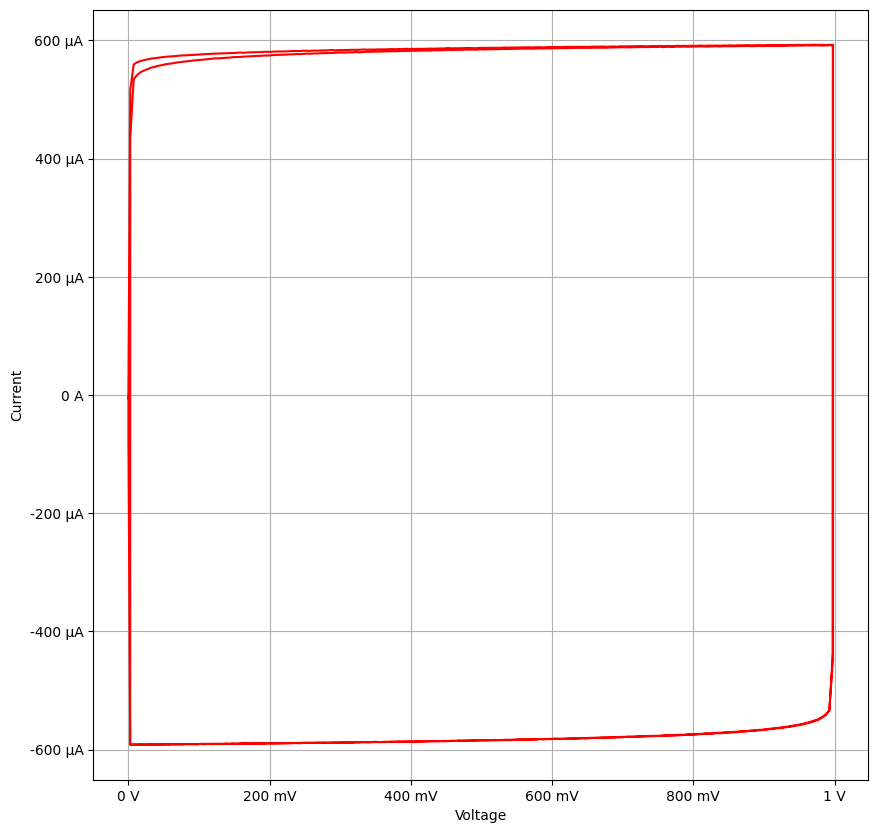

In [19]:
CVmeasurementData = IscImport(measDataInterface.getLatestReceivedFile().binaryData)
maximumCurrent = max(CVmeasurementData.getCurrentArray())
minimumCurrent = min(CVmeasurementData.getCurrentArray())

capacitanceCV = ((maximumCurrent - minimumCurrent) / 2) / scanRate

capacitanceFormatter = EngFormatter(places=3, unit="F", sep="")
print(f"Capacitance CV: {capacitanceFormatter.format_data(capacitanceCV)}")

figCV, (axis) = plt.subplots(1, 1)

axis.plot(
    CVmeasurementData.getVoltageArray(),
    CVmeasurementData.getCurrentArray(),
    color="red",
)

axis.grid(which="both")
axis.xaxis.set_major_formatter(EngFormatter(unit="V"))
axis.yaxis.set_major_formatter(EngFormatter(unit="A"))
axis.set_xlabel(r"Voltage")
axis.set_ylabel(r"Current")

figCV.set_size_inches(10, 10)
plt.show()
figCV.savefig("CV.pdf")

# Performing an EIS Measurement

The impedance measurement parameters are set using the appropriate setter methods so that the measurement is performed at 1 V with 10 mV amplitude.

In [20]:
zahnerZennium.setEISNaming("individual")
zahnerZennium.setEISOutputPath(r"C:\THALES\temp")
zahnerZennium.setEISOutputFileName("eis_measurement")

zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_POTENTIOSTATIC)
zahnerZennium.setAmplitude(10e-3)
zahnerZennium.setPotential(1)
zahnerZennium.setLowerFrequencyLimit(5)
zahnerZennium.setStartFrequency(1000)
zahnerZennium.setUpperFrequencyLimit(500000)
zahnerZennium.setLowerNumberOfPeriods(3)
zahnerZennium.setLowerStepsPerDecade(3)
zahnerZennium.setUpperNumberOfPeriods(20)
zahnerZennium.setUpperStepsPerDecade(5)
zahnerZennium.setScanDirection("startToMin")
zahnerZennium.setScanStrategy("single")

zahnerZennium.enablePotentiostat()
zahnerZennium.measureEIS()
zahnerZennium.disablePotentiostat()

zahnerZennium.setAmplitude(0)

'OK\r'

# Processing the EIS Measurement Data

After the measurement, the impedance spectrum is plotted on a Bode plot using Matplotlib and the parameters of an equivalent circuit model are fitted to the data.

The fitting is done using the Python package [zahner_analysis](https://pypi.org/project/zahner-analysis/), which allows equivalent circuit models to be fitted to impedance spectra. The Python library is a client for the [REST interface](https://en.wikipedia.org/wiki/Representational_state_transfer) of the [Zahner Analysis](https://zahner.de/products-details/software/Zahner-Analysis) module Remote Evaluation. This module is [optional and must be selected for installation](https://doc.zahner.de/zahner_analysis/analysis_connection.html#basic-informations) when the [Zahner Analysis](https://zahner.de/products-details/software/Zahner-Analysis) software is installed.

An equivalent circuit model for an impedance measurement can be easily developed using the graphical interface of the [Zahner Analysis](https://zahner.de/products-details/software/Zahner-Analysis) software. The *Magic Wand Preset Element Tool* can be used to easily determine appropriate initial values for the fit.


In [21]:
EISmeasurementData = IsmImport(measDataInterface.getLatestReceivedFile().binaryData)

zenniumConnection.disconnectFromTerm()
measDataInterface.close()

The [IsfxModelImport](https://doc.zahner.de/zahner_analysis/file_import/index.html#zahner_analysis.file_import.impedance_model_import.IsfxModelImport) class imports models created with the [Zahner Analysis Software](https://zahner.de/products-details/software/Zahner-Analysis) into Python in isfx format. isfx is an [XML](https://en.wikipedia.org/wiki/XML) based format. 

The model is a series connection of a capacitor, an inductor, and a resistor. The initial values of the parameters for the fit are printed to the console.

In [22]:
impedanceCircuitModel = IsfxModelImport("rlc-model.isfx")
print("fit start values:")
print(impedanceCircuitModel)

fit start values:
inductor : L0
      L:  1.000e-07 H        fixed: False
capacitor : C0
      C:  1.000e-05 F        fixed: False
resistor : R0
      R:  1.000e+02 Ω        fixed: False



Fitting via the REST interface is realized with the class [EisFitting](https://doc.zahner.de/zahner_analysis/analyze/index).

Optional parameters are specified for the fit and the simulation to change the frequency ranges. These parameters are explained in more detail in the [example from the zahner_analysis repository](https://github.com/Zahner-elektrik/Zahner-Analysis-Python/blob/main/Examples/ComplexFitConfigurations/ComplexFitConfigurations.ipynb).

In [23]:
fitting = EisFitting()

fitParams = {
    "UpperFrequencyLimit": 200e3,
    "DataSource": "zhit",  # "original", "smoothed" or "zhit"
    "Smoothness": 0.0002,
}

simulationParams = {
    "UpperFrequencyLimit": 10e6,
    "LowerFrequencyLimit": 500e-3,
    "NumberOfSamples": 150,
}

simulatedData = fitting.simulate(impedanceCircuitModel, simulationParams)

After simulating the model with initial values, everything is plotted using the plot functions from the [zahner_analysis](https://pypi.org/project/zahner-analysis/) package, which uses [Matplotlib](https://matplotlib.org/).

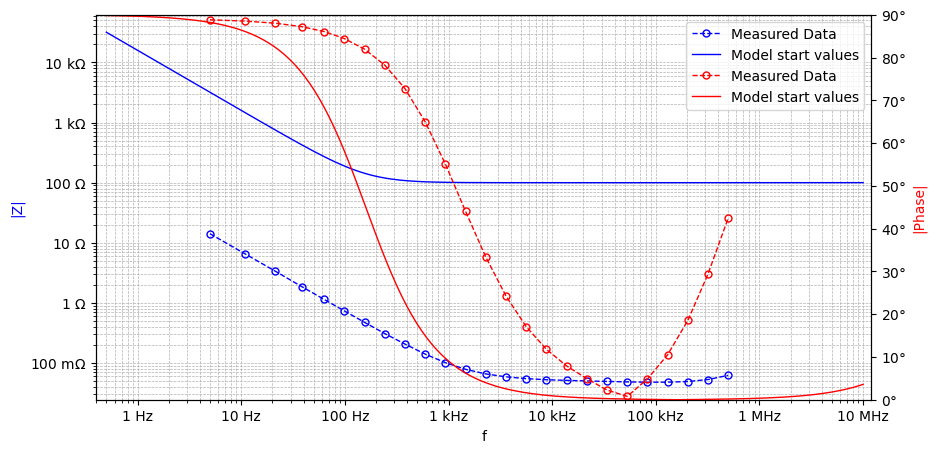

In [24]:
(fig1, (impedanceAxis1, phaseAxis1)) = bodePlotter(impedanceObject=EISmeasurementData)
fig1.set_size_inches(10, 5)
fig1.savefig("EIS.pdf")

(fig1, (impedanceAxis1, phaseAxis1)) = bodePlotter(
    (impedanceAxis1, phaseAxis1),
    impedanceObject=simulatedData,
    argsImpedanceAxis={"linestyle": "solid", "marker": None},
    argsPhaseAxis={"linestyle": "solid", "marker": None},
)

impedanceAxis1.legend(
    impedanceAxis1.get_lines() + phaseAxis1.get_lines(),
    2 * ["Measured Data", "Model start values"],
)
fig1.set_size_inches(10, 5)
plt.show()

The [fit()](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFitting.fit) method is then used to fit the model to the data. Optional parameters are also possible, which are explained in the [API documentation](https://doc.zahner.de/zahner_analysis/) and used in another example.

The [fit()](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFitting.fit) method returns an [EisFittingResult](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult) object containing the results.

It then returns the capacity of the fitted model and the complete fitting result.

In [25]:
fittingResult = fitting.fit(
    impedanceCircuitModel,
    EISmeasurementData,
    fitParams=fitParams,
    simulationParams=simulationParams,
)

capacitanceEIS = fittingResult.getFittedModel()["C0"]["C"].getValue()
print(f"Capacitance EIS: {capacitanceFormatter.format_data(capacitanceEIS)}")

print(fittingResult)

Capacitance EIS: 2.130mF
Fitted Model:
inductor : L0
      L:  1.149e-08 H        fixed: False
capacitor : C0
      C:  2.130e-03 F        fixed: False
resistor : R0
      R:  5.175e-02 Ω        fixed: False
JSON fit result:
{
  "model": {
    "C0": {
      "C": {
        "error": 4.770826449242618,
        "significance": 0.9989940349959059,
        "value": 0.002129922580748168,
        "value_unit": "F"
      }
    },
    "L0": {
      "L": {
        "error": 40.17817901285381,
        "significance": 0.2374315478504917,
        "value": 1.149349273104619e-08,
        "value_unit": "H"
      }
    },
    "R0": {
      "R": {
        "error": 5.263534190263931,
        "significance": 0.9988158387863799,
        "value": 0.051748581793880775,
        "value_unit": "Ω"
      }
    }
  },
  "overall": {
    "impedance_error_max": 7.832394320860368,
    "impedance_error_mean": 0.9455744890996465,
    "overall_error": 13.747479535532275,
    "phase_error_max": 3.1664318342182014,
    "ph

The curve for the model with the fitted parameters and the original measurement data is also displayed and saved.

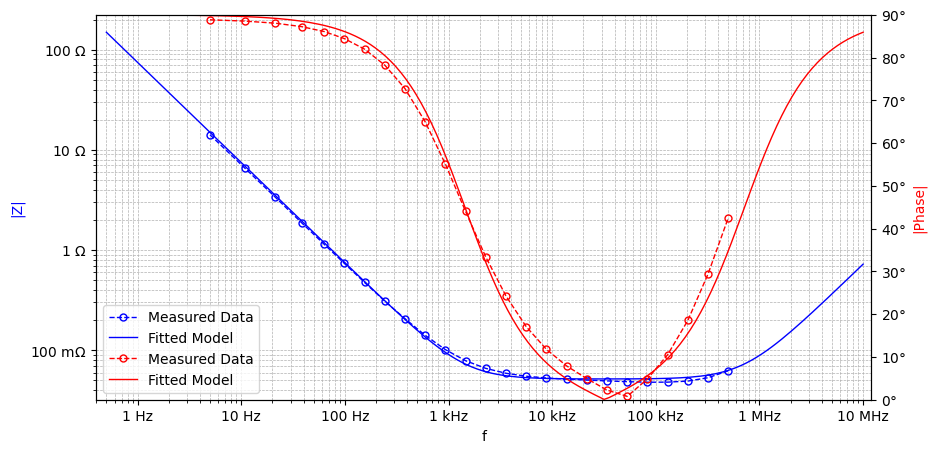

In [26]:
(fig2, (impedanceAxis2, phaseAxis2)) = EisFittingPlotter.plotBode(
    fittingResult, EISmeasurementData
)
impedanceAxis2.legend(
    impedanceAxis2.get_lines() + phaseAxis2.get_lines(),
    2 * ["Measured Data", "Fitted Model"],
    loc="lower left",  # with capacitors, there are never measurement data at this position
)
fig2.set_size_inches(10, 5)
plt.show()

fig2.savefig("EIS_fitted.pdf")

To be able to draw a table with the impedance measurement points in the PDF, the measurement data is exported as csv.

For LaTeX, some small adjustments are necessary to display the micro sign ($\mu$) and the minus sign correctly.  
Everything is written with [utf-8 encoding](https://en.wikipedia.org/wiki/UTF-8), so that all characters can be displayed without problems.

In [27]:
mpl.rcParams["axes.unicode_minus"] = False
prefixFormatter = EngFormatter(places=3, sep="")
defaultMu = prefixFormatter.ENG_PREFIXES[-6]
prefixFormatter.ENG_PREFIXES[-6] = "\\textmu"  # LaTeX notation for micro

with open("EIS.csv", "wb") as file:
    file.write(bytearray("Frequency;Impedance;Phase" + os.linesep, "utf-8"))

    for freq, imp, phase in zip(
        EISmeasurementData.getFrequencyArray(),
        EISmeasurementData.getImpedanceArray(),
        EISmeasurementData.getPhaseArray(),
    ):
        file.write(
            bytearray(
                f"{prefixFormatter.format_data(freq)};{prefixFormatter.format_data(imp)};{prefixFormatter.format_data(phase * (360 / (2 * np.pi)))}"
                + os.linesep,
                "utf-8",
            )
        )

# Generate Report

First, the Python command line input function [input()](https://docs.python.org/3/library/functions.html?highlight=input#input) is used to prompt the user for a name (**objectName**) for the test object.

Fitting results are stored in a subdirectory named after the object.

In [28]:
objectName = input("Input Test Object Identifier:")

EISmeasurementData.save(f"{objectName}.ism")

fittingResult.save(
    path=f"{objectName}_result",
    exist_ok=True,
    saveFitResultJson=True,
    saveFittedModel=True,
    saveFittedSimulatedSamples=True,
    saveFitInputSamples=True,
    fitResultJsonFilename="fit_result.json",
    fittedModelFilename="fitted.isfx",
    fittedSimulatedDataFilename="fitted_simulated.ism",
    fitInputDataFilename="fit_samples.ism",
)

To create a PDF, [LaTeX](https://www.latex-project.org/)/[MiKTeX](https://miktex.org/) is used. For this purpose, a tex-file is created as template which has placeholders for the [Jinja2](https://palletsprojects.com/p/jinja/) template engine. These placeholders are filled in with Python.

The placeholder for capacity is, for example: <code>\PYVAR{capacitance}</code>.

In the following, the Jinja2 enviroment is [initialized](http://eosrei.net/articles/2015/11/latex-templates-python-and-jinja2-generate-pdfs) and the template file is loaded.

In [29]:
latex_jinja_env = jinja2.Environment(
    variable_start_string="\PYVAR{",
    variable_end_string="}",
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath(".")),
)

template = latex_jinja_env.get_template(r"report.tex")

The render method fills in the [Jinja2](https://palletsprojects.com/p/jinja/) placeholders. The assignments in the parameter list are used to pass the data from Python to the placeholders.

The table with the impedance measurement data is displayed by LaTeX, while the data is stored in the created csv file. Only the filename of the csv file is passed.

The filled LaTeX file is then written to disk and [pdflatex.exe](https://docs.miktex.org/manual/miktex-pdftex.html) is called with appropriate parameters to create the PDF file.  
The *-jobname* parameter specifies the name of the PDF file to be created.

Finally, the created PDF file is opened.

In [30]:
currentFormatter = EngFormatter(places=3, unit="A", sep="")
currentFormatter.ENG_PREFIXES[-6] = "\\mu "  # LaTeX notation for micro
resistanceFormatter = EngFormatter(places=3, unit="$\Omega$", sep="")
resistanceFormatter.ENG_PREFIXES[-6] = "\\mu "
inductanceFormatter = EngFormatter(places=3, unit="H", sep="")
inductanceFormatter.ENG_PREFIXES[-6] = "\\mu "

fittedModel = fittingResult.getFittedModel()
fitResult = fittingResult.getFitResultJson()

fileString = template.render(
    objectname=objectName,
    capacitance_cv=capacitanceFormatter.format_data(capacitanceCV),
    cv_filename="CV.pdf",
    eis_filename="EIS.pdf",
    eis_fitted_filename="EIS_fitted.pdf",
    eis_csv_filename="EIS.csv",
    cv_maximum_current=currentFormatter.format_data(maximumCurrent),
    cv_minimum_current=currentFormatter.format_data(minimumCurrent),
    cv_scanrate=scanRate,
    capacitance_eis=capacitanceFormatter.format_data(capacitanceEIS),
    capacitance_eis_error=f"{fitResult['model']['C0']['C']['error']:.1f}",
    resistance_eis=resistanceFormatter.format_data(fittedModel["R0"]["R"].getValue()),
    resistance_eis_error=f"{fitResult['model']['R0']['R']['error']:.1f}",
    inductance_eis=inductanceFormatter.format_data(fittedModel["L0"]["L"].getValue()),
    inductance_eis_error=f"{fitResult['model']['L0']['L']['error']:.1f}",
)

fileString = bytearray(fileString, "utf-8")
f = open("report_filled.tex", "wb")
f.write(fileString)
f.close()

# only needed for Jupyter, that the kernel does not have to be restarted all the time.
prefixFormatter.ENG_PREFIXES[-6] = defaultMu
currentFormatter.ENG_PREFIXES[-6] = defaultMu
resistanceFormatter.ENG_PREFIXES[-6] = defaultMu
inductanceFormatter.ENG_PREFIXES[-6] = defaultMu

# close pdf viewer so that the pdf can be overwritten for debugging
os.system("taskkill /IM Acrobat.exe /T /F")

command = f'pdflatex.exe report_filled.tex -jobname="{objectName}"'
os.system(command)
os.popen(f"{objectName}.pdf")
print("finish")

finish
